# BigMart Sales Prediction Project

**Goal:**  
Predict the sales for each product in BigMart outlets based on historical sales and product/store attributes.

**Dataset:**  
- **train.csv** — contains product/store details and actual sales (target variable `Item_Outlet_Sales`)  
- **test.csv** — similar structure but without sales (we must predict these)

**Steps in this notebook:**
1. Load train & test datasets
2. Data Cleaning (fix categories, impute missing values)
3. Feature Engineering
4. Exploratory Data Analysis (EDA)
5. Model Training with 5-fold Cross-Validation
6. Final model fitting & predictions
7. Save submission file
8. Display top feature importances


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from IPython.display import FileLink


# Load Train & Test Data

In [2]:
train = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()



Train shape: (8523, 12)
Test shape: (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Data Cleaning


In [3]:
train['Item_Fat_Content'] = train['Item_Fat_Content'].replace({
    'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'
})
test['Item_Fat_Content'] = test['Item_Fat_Content'].replace({
    'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'
})


item_weight_mean = train.groupby('Item_Identifier')['Item_Weight'].mean()
train['Item_Weight'] = train.apply(lambda row: item_weight_mean[row['Item_Identifier']] 
                                   if pd.isnull(row['Item_Weight']) else row['Item_Weight'], axis=1)
test['Item_Weight'] = test.apply(lambda row: item_weight_mean.get(row['Item_Identifier'], np.nan) 
                                 if pd.isnull(row['Item_Weight']) else row['Item_Weight'], axis=1)


outlet_size_mode = train.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=lambda x: x.mode()[0])
for df in [train, test]:
    df['Outlet_Size'] = df.apply(
        lambda row: outlet_size_mode[row['Outlet_Type']].iloc[0] if pd.isnull(row['Outlet_Size']) else row['Outlet_Size'],
        axis=1
    )


# Feature Engineering

In [4]:

for df in [train, test]:
    df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])


for df in [train, test]:
    df['Outlet_Age'] = 2013 - df['Outlet_Establishment_Year']


le = LabelEncoder()
cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
            'Outlet_Type', 'Item_Category', 'Outlet_Identifier']

for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])


# EDA: Missing Values

In [5]:
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0]
missing_train


Item_Weight    4
dtype: int64

# EDA: Sales Distribution

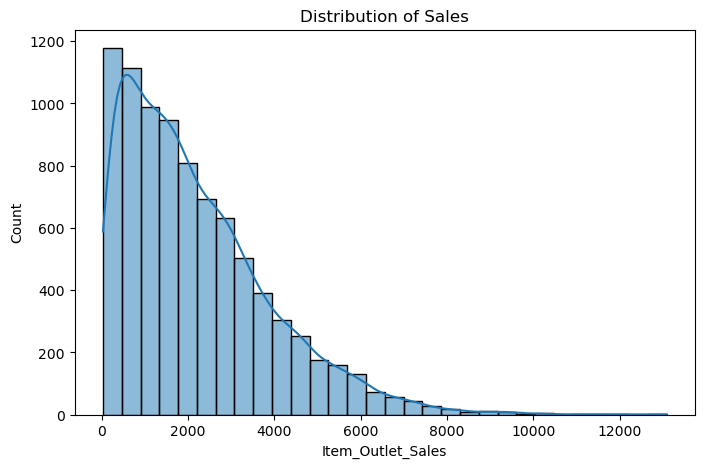

In [6]:
plt.figure(figsize=(8,5))
sns.histplot(train['Item_Outlet_Sales'], bins=30, kde=True)
plt.title("Distribution of Sales")
plt.show()


# Prepare Data for Modeling

In [7]:
target = 'Item_Outlet_Sales'
features = [col for col in train.columns if col not in [target, 'Item_Identifier']]

X = train[features]
y = train[target]
X_test = test[features]


# Model Training

In [8]:
from sklearn.preprocessing import LabelEncoder

X = train.drop(columns=['Item_Outlet_Sales']).copy()
y = train['Item_Outlet_Sales']

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

if X.isnull().sum().any():
    X = X.fillna(0)

model = RandomForestRegressor(
    n_estimators=600,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = -1 * cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf)

print("CV RMSE scores:", cv_scores)
print("Mean CV RMSE:", np.mean(cv_scores))


CV RMSE scores: [1036.45501046 1089.61092354 1090.359007   1133.99022729 1135.30205951]
Mean CV RMSE: 1097.1434455604076


# Fit Final Model & Predict Test

In [9]:
train = pd.read_csv("train_v9rqX0R.csv")
test = pd.read_csv("test_AbJTz2l.csv")

X = train.drop(columns=['Item_Outlet_Sales']).copy()
y = train['Item_Outlet_Sales']

le_dict = {}  
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le  

if X.isnull().sum().any():
    X = X.fillna(0)

model = RandomForestRegressor(
    n_estimators=600,
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)


model.fit(X, y)

X_test = test.copy()
for col in X_test.select_dtypes(include=['object']).columns:
    if col in le_dict:
        X_test[col] = le_dict[col].transform(X_test[col].astype(str))
    else:
        X_test[col] = LabelEncoder().fit_transform(X_test[col].astype(str))  # fallback

if X_test.isnull().sum().any():
    X_test = X_test.fillna(0)


test_pred = model.predict(X_test)


submission = pd.DataFrame({
    'Item_Identifier': test['Item_Identifier'],
    'Outlet_Identifier': test['Outlet_Identifier'],
    'Item_Outlet_Sales': test_pred
})


submission.to_csv("BigMart_Submission.csv", index=False)
print("Submission CSV created successfully!")

# Create a download link for the CSV in Jupyter Notebook
FileLink("BigMart_Submission.csv")


Submission CSV created successfully!


C:\Users\karne\BigMart_Submission.csv

# Feature Importances

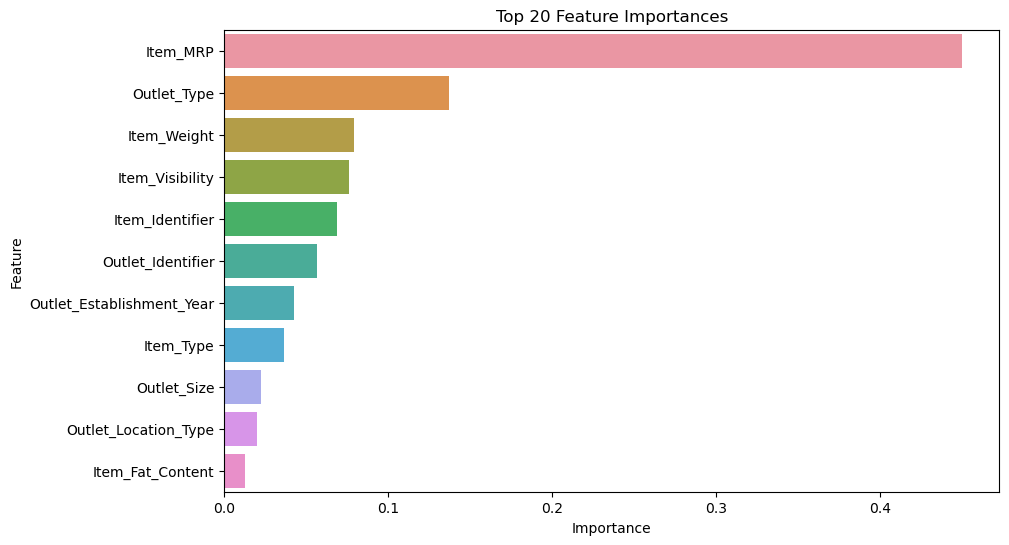

In [10]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importances.head(20), x='Importance', y='Feature')
plt.title("Top 20 Feature Importances")
plt.show()
